In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import log_loss, accuracy_score, classification_report, plot_confusion_matrix, balanced_accuracy_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

In [2]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
sample = pd.read_csv('../input/sample_submission.csv')

In [3]:
lbl_enc = preprocessing.LabelEncoder()
y = lbl_enc.fit_transform(train.author.values)

In [4]:
history = pd.DataFrame(
    [],
    columns=pd.MultiIndex.from_product([['train', 'validate'], ['logloss', 'accuracy']]),
    dtype='float32'
)

def evaluate_model(clf, slug, xtrain, ytrain, xvalid, yvalid, fit=True):
    global history
    if fit:
        clf.fit(xtrain, ytrain)

    # print loss values
    predictions = clf.predict_proba(xtrain)
    print ("train set: logloss: %0.3f" % (log_loss(ytrain, predictions), ))
    history.loc[slug, ('train', 'logloss')] = log_loss(ytrain, predictions)
    predictions = clf.predict_proba(xvalid)
    print ("valid set: logloss: %0.3f" % (log_loss(yvalid, predictions), ))
    history.loc[slug, ('validate', 'logloss')] = log_loss(yvalid, predictions)
    
    # print accuracy matrix
    predictions = clf.predict(xtrain)
    print('train set')
    print(classification_report(ytrain, predictions, target_names=lbl_enc.classes_, digits=3))
    print('-' * 70)
    predictions = clf.predict(xvalid)
    print('validate set')
    print(classification_report(yvalid, predictions, target_names=lbl_enc.classes_, digits=3))

    plot_confusion_matrix(clf, xvalid, yvalid, display_labels=lbl_enc.classes_, values_format='d', cmap='Blues')
    plt.grid(False)
    
    history.loc[slug, ('train', 'accuracy')] = balanced_accuracy_score(ytrain, clf.predict(xtrain))
    history.loc[slug, ('validate', 'accuracy')] = balanced_accuracy_score(yvalid, clf.predict(xvalid))


## 训练样本拆分

In [5]:
xtrain, xvalid, ytrain, yvalid = train_test_split(
    train.text.values, y, 
    stratify=y, 
    random_state=42, 
    test_size=0.1, shuffle=True
)

print('origin:', np.bincount(y)/len(y))
print('train:', np.bincount(ytrain)/len(ytrain))
print('valid:', np.bincount(yvalid)/len(yvalid))

origin: [0.40349354 0.28780837 0.30869809]
train: [0.40349583 0.28778162 0.30872255]
valid: [0.40347293 0.28804903 0.30847804]


## 默认词袋

无停用词、Ngram，保留两个字母以上的单词 ([API](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer))

In [6]:
ctv = CountVectorizer()
ctv.fit(list(xtrain) + list(xvalid))
xtrain_ctv =  ctv.transform(xtrain) 
xvalid_ctv = ctv.transform(xvalid)

In [7]:
features = np.array(ctv.get_feature_names())
print('# of features:', len(features))

# of features: 25068


In [8]:
print(xtrain[1])
print(xtrain_ctv[1])
print(xtrain_ctv[1].nonzero()[1])
print(features[xtrain_ctv[1].nonzero()[1]])
features[14491]

"No," he said, "oh, no a member of my family my niece, and a most accomplished woman."
  (0, 152)	1
  (0, 837)	1
  (0, 8307)	1
  (0, 10316)	1
  (0, 13778)	1
  (0, 14298)	1
  (0, 14491)	2
  (0, 14767)	1
  (0, 14817)	2
  (0, 15145)	1
  (0, 15178)	1
  (0, 19088)	1
  (0, 24768)	1
[  152   837  8307 10316 13778 14298 14491 14767 14817 15145 15178 19088
 24768]
['accomplished' 'and' 'family' 'he' 'member' 'most' 'my' 'niece' 'no' 'of'
 'oh' 'said' 'woman']


'my'

train set: logloss: 0.109
valid set: logloss: 0.451
train set
              precision    recall  f1-score   support

         EAP      0.982     0.994     0.988      7110
         HPL      0.995     0.988     0.991      5071
         MWS      0.993     0.985     0.989      5440

    accuracy                          0.989     17621
   macro avg      0.990     0.989     0.989     17621
weighted avg      0.989     0.989     0.989     17621

----------------------------------------------------------------------
validate set
              precision    recall  f1-score   support

         EAP      0.808     0.862     0.834       790
         HPL      0.867     0.812     0.839       564
         MWS      0.825     0.801     0.813       604

    accuracy                          0.829      1958
   macro avg      0.833     0.825     0.829      1958
weighted avg      0.830     0.829     0.829      1958



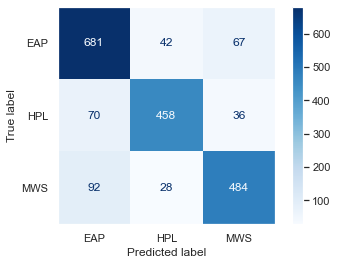

In [9]:
evaluate_model(
    LogisticRegression(C=1.7825594, max_iter=1000),
    'Basic BoW',
    xtrain_ctv, ytrain,
    xvalid_ctv, yvalid,
)

## Ngram词袋

考虑部分词语的顺序

In [10]:
ctv = CountVectorizer(ngram_range=(1, 3))
ctv.fit(list(xtrain) + list(xvalid))
xtrain_ctv =  ctv.transform(xtrain) 
xvalid_ctv = ctv.transform(xvalid)

In [11]:
features = np.array(ctv.get_feature_names())
print('# of features:', len(features))

# of features: 642857


In [12]:
print(xtrain[1])
print(xtrain_ctv[1])
print(features[xtrain_ctv[1].nonzero()[1]])

"No," he said, "oh, no a member of my family my niece, and a most accomplished woman."
  (0, 2675)	1
  (0, 2711)	1
  (0, 20559)	1
  (0, 30486)	1
  (0, 30488)	1
  (0, 168862)	1
  (0, 168968)	1
  (0, 168969)	1
  (0, 219715)	1
  (0, 222588)	1
  (0, 222620)	1
  (0, 313622)	1
  (0, 313623)	1
  (0, 313626)	1
  (0, 324163)	1
  (0, 324181)	1
  (0, 324182)	1
  (0, 329223)	2
  (0, 330872)	1
  (0, 330880)	1
  (0, 332667)	1
  (0, 332668)	1
  (0, 341079)	1
  (0, 341080)	1
  (0, 341081)	1
  (0, 342089)	2
  (0, 342727)	1
  (0, 342732)	1
  (0, 343122)	1
  (0, 343123)	1
  (0, 354724)	1
  (0, 363641)	1
  (0, 363798)	1
  (0, 374142)	1
  (0, 374246)	1
  (0, 374252)	1
  (0, 437522)	1
  (0, 437925)	1
  (0, 437926)	1
  (0, 631344)	1
['accomplished' 'accomplished woman' 'and' 'and most'
 'and most accomplished' 'family' 'family my' 'family my niece' 'he'
 'he said' 'he said oh' 'member' 'member of' 'member of my' 'most'
 'most accomplished' 'most accomplished woman' 'my' 'my family'
 'my family my' 'my niece'

train set: logloss: 0.024
valid set: logloss: 0.465
train set
              precision    recall  f1-score   support

         EAP      1.000     1.000     1.000      7110
         HPL      1.000     1.000     1.000      5071
         MWS      1.000     1.000     1.000      5440

    accuracy                          1.000     17621
   macro avg      1.000     1.000     1.000     17621
weighted avg      1.000     1.000     1.000     17621

----------------------------------------------------------------------
validate set
              precision    recall  f1-score   support

         EAP      0.795     0.885     0.838       790
         HPL      0.853     0.780     0.815       564
         MWS      0.844     0.786     0.814       604

    accuracy                          0.824      1958
   macro avg      0.831     0.817     0.822      1958
weighted avg      0.827     0.824     0.824      1958



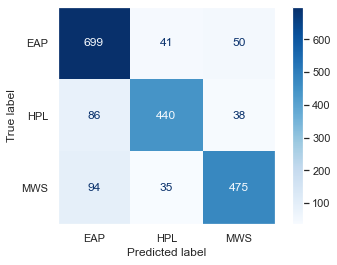

In [13]:
evaluate_model(
    LogisticRegression(C=1.7825594, max_iter=1000),
    'Ngram',
    xtrain_ctv, ytrain,
    xvalid_ctv, yvalid,
)

## 停用词

删去英语常见停用词

In [14]:
ctv = CountVectorizer(ngram_range=(1, 3), stop_words='english')
ctv.fit(list(xtrain) + list(xvalid))
xtrain_ctv =  ctv.transform(xtrain) 
xvalid_ctv = ctv.transform(xvalid)

In [15]:
features = np.array(ctv.get_feature_names())
print('# of features:', len(features))

# of features: 397066


In [16]:
print(' '.join(sorted(ctv.get_stop_words())))

a about above across after afterwards again against all almost alone along already also although always am among amongst amoungst amount an and another any anyhow anyone anything anyway anywhere are around as at back be became because become becomes becoming been before beforehand behind being below beside besides between beyond bill both bottom but by call can cannot cant co con could couldnt cry de describe detail do done down due during each eg eight either eleven else elsewhere empty enough etc even ever every everyone everything everywhere except few fifteen fifty fill find fire first five for former formerly forty found four from front full further get give go had has hasnt have he hence her here hereafter hereby herein hereupon hers herself him himself his how however hundred i ie if in inc indeed interest into is it its itself keep last latter latterly least less ltd made many may me meanwhile might mill mine more moreover most mostly move much must my myself name namely neithe

In [17]:
print(features[xtrain_ctv[0].nonzero()[1]])

['brightest' 'brightest living' 'brightest living gold' 'clothing'
 'clothing set' 'clothing set crown' 'crown' 'crown distinction'
 'crown distinction head' 'despite' 'despite poverty'
 'despite poverty clothing' 'distinction' 'distinction head' 'gold'
 'gold despite' 'gold despite poverty' 'hair' 'hair brightest'
 'hair brightest living' 'head' 'living' 'living gold'
 'living gold despite' 'poverty' 'poverty clothing' 'poverty clothing set'
 'set' 'set crown' 'set crown distinction']


train set: logloss: 0.055
valid set: logloss: 0.524
train set
              precision    recall  f1-score   support

         EAP      0.994     1.000     0.997      7110
         HPL      1.000     0.997     0.998      5071
         MWS      1.000     0.996     0.998      5440

    accuracy                          0.998     17621
   macro avg      0.998     0.997     0.998     17621
weighted avg      0.998     0.998     0.998     17621

----------------------------------------------------------------------
validate set
              precision    recall  f1-score   support

         EAP      0.736     0.857     0.792       790
         HPL      0.855     0.709     0.775       564
         MWS      0.793     0.748     0.770       604

    accuracy                          0.781      1958
   macro avg      0.795     0.772     0.779      1958
weighted avg      0.788     0.781     0.780      1958



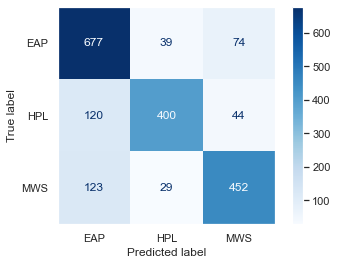

In [18]:
evaluate_model(
    LogisticRegression(C=1.7825594, max_iter=1000),
    'Stopwords',
    xtrain_ctv, ytrain,
    xvalid_ctv, yvalid,
)

另一个Stopwords词库（NLTK） 

In [19]:
from nltk.corpus import stopwords
english_stopwords = set(stopwords.words('english'))

In [20]:
ctv = CountVectorizer(ngram_range=(1, 3), stop_words=english_stopwords)
ctv.fit(list(xtrain) + list(xvalid))
xtrain_ctv =  ctv.transform(xtrain) 
xvalid_ctv = ctv.transform(xvalid)

In [21]:
features = np.array(ctv.get_feature_names())
print('# of features:', len(features))

# of features: 447740


In [22]:
print(' '.join(sorted(ctv.get_stop_words())))

a about above after again against ain all am an and any are aren aren't as at be because been before being below between both but by can couldn couldn't d did didn didn't do does doesn doesn't doing don don't down during each few for from further had hadn hadn't has hasn hasn't have haven haven't having he her here hers herself him himself his how i if in into is isn isn't it it's its itself just ll m ma me mightn mightn't more most mustn mustn't my myself needn needn't no nor not now o of off on once only or other our ours ourselves out over own re s same shan shan't she she's should should've shouldn shouldn't so some such t than that that'll the their theirs them themselves then there these they this those through to too under until up ve very was wasn wasn't we were weren weren't what when where which while who whom why will with won won't wouldn wouldn't y you you'd you'll you're you've your yours yourself yourselves


In [23]:
print(features[xtrain_ctv[0].nonzero()[1]])

['brightest' 'brightest living' 'brightest living gold' 'clothing'
 'clothing seemed' 'clothing seemed set' 'crown' 'crown distinction'
 'crown distinction head' 'despite' 'despite poverty'
 'despite poverty clothing' 'distinction' 'distinction head' 'gold'
 'gold despite' 'gold despite poverty' 'hair' 'hair brightest'
 'hair brightest living' 'head' 'living' 'living gold'
 'living gold despite' 'poverty' 'poverty clothing'
 'poverty clothing seemed' 'seemed' 'seemed set' 'seemed set crown' 'set'
 'set crown' 'set crown distinction']


train set: logloss: 0.046
valid set: logloss: 0.505
train set
              precision    recall  f1-score   support

         EAP      0.997     1.000     0.998      7110
         HPL      1.000     0.998     0.999      5071
         MWS      1.000     0.998     0.999      5440

    accuracy                          0.999     17621
   macro avg      0.999     0.998     0.999     17621
weighted avg      0.999     0.999     0.999     17621

----------------------------------------------------------------------
validate set
              precision    recall  f1-score   support

         EAP      0.765     0.875     0.816       790
         HPL      0.856     0.746     0.797       564
         MWS      0.812     0.757     0.783       604

    accuracy                          0.801      1958
   macro avg      0.811     0.793     0.799      1958
weighted avg      0.806     0.801     0.801      1958



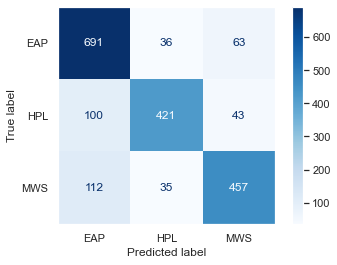

In [24]:
evaluate_model(
    LogisticRegression(C=1.7825594, max_iter=1000),
    'NLTK Stopwords',
    xtrain_ctv, ytrain,
    xvalid_ctv, yvalid,
)

## 离散概率模型

In [25]:
ctv = CountVectorizer(binary=True)
ctv.fit(list(xtrain) + list(xvalid))
xtrain_ctv =  ctv.transform(xtrain) 
xvalid_ctv = ctv.transform(xvalid)

In [26]:
features = np.array(ctv.get_feature_names())
print('# of features:', len(features))

# of features: 25068


In [27]:
print(xtrain[1])
print(xtrain_ctv[1])
print(xtrain_ctv[1].nonzero()[1])
print(features[xtrain_ctv[1].nonzero()[1]])
features[14491]

"No," he said, "oh, no a member of my family my niece, and a most accomplished woman."
  (0, 152)	1
  (0, 837)	1
  (0, 8307)	1
  (0, 10316)	1
  (0, 13778)	1
  (0, 14298)	1
  (0, 14491)	1
  (0, 14767)	1
  (0, 14817)	1
  (0, 15145)	1
  (0, 15178)	1
  (0, 19088)	1
  (0, 24768)	1
[  152   837  8307 10316 13778 14298 14491 14767 14817 15145 15178 19088
 24768]
['accomplished' 'and' 'family' 'he' 'member' 'most' 'my' 'niece' 'no' 'of'
 'oh' 'said' 'woman']


'my'

train set: logloss: 0.110
valid set: logloss: 0.449
train set
              precision    recall  f1-score   support

         EAP      0.983     0.993     0.988      7110
         HPL      0.995     0.988     0.991      5071
         MWS      0.993     0.985     0.989      5440

    accuracy                          0.989     17621
   macro avg      0.990     0.989     0.989     17621
weighted avg      0.989     0.989     0.989     17621

----------------------------------------------------------------------
validate set
              precision    recall  f1-score   support

         EAP      0.799     0.862     0.829       790
         HPL      0.860     0.809     0.834       564
         MWS      0.825     0.786     0.805       604

    accuracy                          0.823      1958
   macro avg      0.828     0.819     0.823      1958
weighted avg      0.825     0.823     0.823      1958



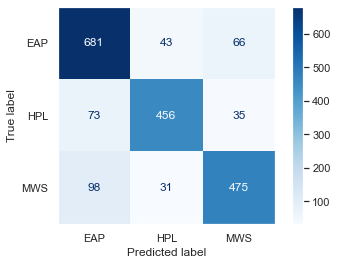

In [28]:
evaluate_model(
    LogisticRegression(C=1.7825594, max_iter=1000),
    'Binary',
    xtrain_ctv, ytrain,
    xvalid_ctv, yvalid,
)

## 结果比较

In [29]:
history.sort_values(by=('validate', 'logloss'))

train            validate          
                 logloss  accuracy   logloss  accuracy
Binary          0.109637  0.988819  0.449018  0.818987
Basic BoW       0.108562  0.988780  0.450666  0.825136
Ngram           0.023737  1.000000  0.464923  0.817125
NLTK Stopwords  0.045928  0.998480  0.505014  0.792587
Stopwords       0.054995  0.997412  0.524187  0.771509

<AxesSubplot:>

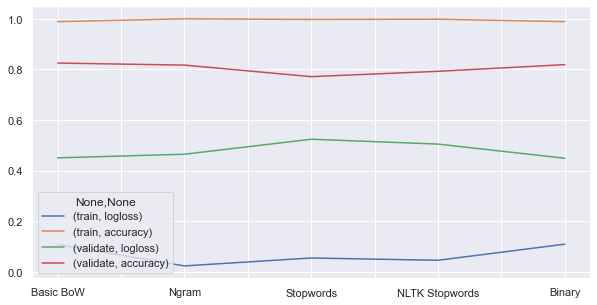

In [30]:
history.plot(figsize=(10, 5))

<AxesSubplot:>

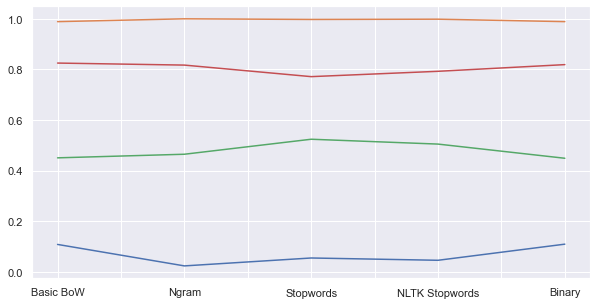

In [31]:
history.plot(figsize=(10, 5), legend=False)